In [1]:
#download dataset from kaggle
import kagglehub
path = kagglehub.dataset_download("adityakadiwal/water-potability", force_download=True)
print("Path to dataset files:", path)

# Import das Bibliotecas
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import mlflow

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.metrics import brier_score_loss as brier
from sklearn.metrics import log_loss, precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/aexpedito/mlflow/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 251k/251k [00:00<00:00, 475kB/s]

Extracting files...



2025-01-14 15:43:03.792811: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.


Path to dataset files: /home/aexpedito/.cache/kagglehub/datasets/adityakadiwal/water-potability/versions/3


2025-01-14 15:43:03.803188: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 15:43:03.820715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736880183.838806   81031 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736880183.844109   81031 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 15:43:03.874057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

In [2]:
# abrindo arquivo
data_df = pd.read_csv(path + '/water_potability.csv')

In [3]:
#dropa linhas com NA
data_df.dropna(inplace=True)

In [4]:
# Split dos dados
data_df_train, data_df_test = train_test_split(data_df, test_size=0.30, random_state=0, shuffle=True)

In [5]:
# Normalização dos dados numéricos
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

numeric_features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']
categorical_features = ['Potability']
transformer = ColumnTransformer([
    ('numeric', MinMaxScaler(), numeric_features)
])

X_train = transformer.fit_transform(data_df_train)
features = transformer.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(transformer.transform(data_df_test), columns=features)

y_train = data_df_train['Potability']
y_test = data_df_test['Potability']

In [7]:
#Funçoes utilizadas
def get_model_metrics(model_name, threshold, y_prob, y_test):
    # salvando resultado
    y_pred = (y_prob > threshold)*1
    acc_estimate = round(acc(y_test,y_pred), 3)
    log_estimate = round(log_loss(y_test,y_prob), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1_score = round(metrics.f1_score(y_test, y_pred), 3)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'all')
    plt.show()


    return pd.DataFrame({
        'Method': [model_name],
        'Acuracia': [acc_estimate],
        "Precisao": [precision],
        "Recall": [recall],
        'F1': [f1_score],
        'Log-loss': [log_estimate]
    })

# Modelo LogisticRegression

In [8]:
models = {}
metricas = pd.DataFrame(columns = ['Method','Acuracia', 'Precisao', "Recall",'F1','Log-loss'])

logistic_none = linear_model.LogisticRegression(penalty=None, max_iter=1000)
logistic_none.fit(X=X_train, y=y_train)

models['Logistica_sem_penalizacao'] = logistic_none

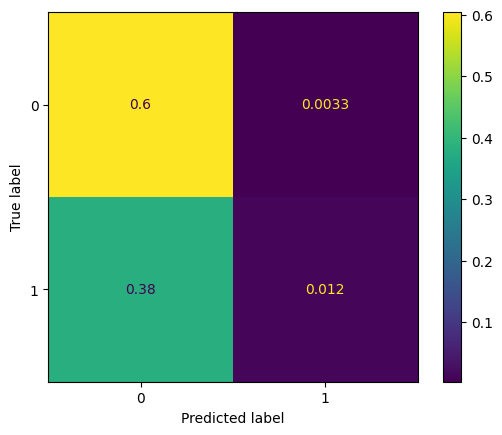

/tmp/ipykernel_81031/1797884712.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metricas = pd.concat([metricas, resultado_modelo])


,Method,Acuracia,Precisao,Recall,F1,Log-loss
0,Logistica_sem_penalizacao,0.616,0.778,0.03,0.057,0.674


In [9]:
#Computa metricas do modelo
resultado_modelo = get_model_metrics(
    model_name='Logistica_sem_penalizacao',
    threshold=.5,
    y_prob=models['Logistica_sem_penalizacao'].predict_proba(X_test)[:,1],
    y_test=y_test)

metricas = pd.concat([metricas, resultado_modelo])
metricas

## Salva no mlflow

In [10]:
# Inicializa o mlflow
mlflow.set_tracking_uri('http://localhost:5001')
mlflow.set_experiment("Potability2")

mlflow.start_run(run_name="Logistica_sem_penalizacao")
parametros = {
    "n_entries": 2011,
    "penalty": None,
}
resultado_modelo = {
    "acuracia" : metricas['Acuracia'],
    "f1": metricas['F1'],
    "log-loss": metricas['F1'],
    "precisao": metricas['Precisao'],
    "recall": metricas['Recall']
}
mlflow.log_params(parametros)
mlflow.log_metrics(resultado_modelo)
mlflow.sklearn.log_model(logistic_none, "linear_no_penalty")
mlflow.end_run()

/home/aexpedito/mlflow/.venv/lib/python3.12/site-packages/mlflow/tracking/metric_value_conversion_utils.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(x)
2025/01/14 15:43:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistica_sem_penalizacao at: http://localhost:5001/#/experiments/3/runs/151b0c6b3f6d4d2c91a4face123d8556
🧪 View experiment at: http://localhost:5001/#/experiments/3


In [ ]:
mlflow.end_run()